In [77]:
import pandas as pd
import numpy as np

# import necessary file
# import swifter
from datetime import datetime
from tqdm.notebook import tqdm, tnrange
tqdm.pandas(desc="Loading...")

# Setting the pyecharts config
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB

# Define pyecharts theme
from pyecharts.globals import ThemeType

# setting pyecharts' charts
from pyecharts.charts import Funnel, Bar, Line, Grid, TreeMap, Page, Pie, Boxplot
from pyecharts import options as opts
from pyecharts.globals import ThemeType

# setting plot
# import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# Using the magic command
%matplotlib inline

/Users/chris/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
#引入資料
df = pd.read_csv('Data/UserBehavior.csv', nrows=10000000, header=None, parse_dates=True)

print('Loading Finished! The file length is {} rows'.format(len(df)))

Loading Finished! The file length is 10000000 rows


In [4]:
# 重新命名欄位
print('Renaming Columns...')

df.columns = ['User_Id', 'Item_Id', 'Category_Id', 'Behavior', 'Time']

print('Renamed column Finished...')

Renaming Columns...
Renamed column Finished...


In [5]:
# 清洗超出時間範圍的數據
print('Filtering data...')

df['Time'] = pd.to_datetime(df['Time'], unit="s")
mask_1 = df['Time'] > datetime(2017,11,24)
mask_2 = df['Time'] < datetime(2017,12,3)
df = df[mask_1 & mask_2]

print('Filtering data Finished!')

Filtering data...
Filtering data Finished!


In [6]:
df = df.reset_index(drop=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8797438 entries, 0 to 8797437
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   User_Id      int64         
 1   Item_Id      int64         
 2   Category_Id  int64         
 3   Behavior     object        
 4   Time         datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 335.6+ MB


In [8]:
df.head()

,User_Id,Item_Id,Category_Id,Behavior,Time
0,1,2268318,2520377,pv,2017-11-24 17:21:10
1,1,2333346,2520771,pv,2017-11-24 22:15:33
2,1,2576651,149192,pv,2017-11-25 01:21:25
3,1,3830808,4181361,pv,2017-11-25 07:04:53
4,1,4365585,2520377,pv,2017-11-25 07:49:06


In [9]:
# 縮減資料量
df_behav = df.loc[:, ['User_Id', 'Time', 'Behavior']]

In [10]:
# 新增所需欄位
df_behav['Date'] = df_behav.Time.dt.date
df_behav['Hour'] = df_behav.Time.dt.hour

In [11]:
# 轉換資料型態
df_behav['Date'] = df_behav.Date.astype('category')
df_behav['Hour'] = df_behav.Hour.astype('category')

df_behav['Behavior'] = df_behav.Behavior.astype('category')
df_behav['User_Id'] = df_behav.User_Id.astype('category')

In [12]:
df_behav = df_behav.reset_index(drop=True)

In [13]:
df_behav.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8797438 entries, 0 to 8797437
Data columns (total 5 columns):
 #   Column    Dtype         
---  ------    -----         
 0   User_Id   category      
 1   Time      datetime64[ns]
 2   Behavior  category      
 3   Date      category      
 4   Hour      category      
dtypes: category(4), datetime64[ns](1)
memory usage: 129.1 MB


In [14]:
df_behav.head()

,User_Id,Time,Behavior,Date,Hour
0,1,2017-11-24 17:21:10,pv,2017-11-24,17
1,1,2017-11-24 22:15:33,pv,2017-11-24,22
2,1,2017-11-25 01:21:25,pv,2017-11-25,1
3,1,2017-11-25 07:04:53,pv,2017-11-25,7
4,1,2017-11-25 07:49:06,pv,2017-11-25,7


----
# 淘寶用戶行為分析內容

## 用戶一週活躍行為：

In [15]:
# 提取所需數據
df_date = df_behav.loc[:, ('User_Id', 'Date')]
df_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8797438 entries, 0 to 8797437
Data columns (total 2 columns):
 #   Column   Dtype   
---  ------   -----   
 0   User_Id  category
 1   Date     category
dtypes: category(2)
memory usage: 45.2 MB


In [16]:
# 計算每日活躍用戶數
daily_active = df_date.groupby('Date')['User_Id'].nunique().reset_index()

# 重新命名欄位
daily_active.columns = ['Date', 'Volume']

In [19]:
def daily_act():
    daily = daily_active.Volume.to_list()[1:]
    week = daily_active.Date.astype(str).str.slice(stop=10).to_list()[1:]
    line = (
        Line()
        .add_xaxis(week)
        .add_yaxis("活躍人數", daily)
        .set_global_opts(
            title_opts=opts.TitleOpts(
                title="每日用戶活躍數"
            )
        )
    )
    return line
daily_act().render_notebook()

### 於 12-02 的活躍高點佔總活躍人數比

In [20]:
# 計算高點人數以及該區間所有的用戶數
high_point = df_behav[df_behav['Date'] == "2017-12-02"].User_Id.nunique()
total_user = df_behav.User_Id.nunique()

# 打印出比例
print('活躍用戶佔比為：{:.2f}%'.format(100 * high_point / total_user))

活躍用戶佔比為：95.46%


## 一週內用戶行為分析：

In [21]:
def week_behav(col):
    '''
    先把日期過濾成一週，再把數據進行透視分析以取出各項數據。
    '''
    df_week = df_behav.pivot_table(index="Date", columns="Behavior", aggfunc=['count']).iloc[:,:4]
    df_week.columns = ['buy', 'cart', 'fav', 'pv']
    behavior = df_week.reset_index()[col].to_list()[1:]
    return behavior
week_behav('pv')

[938025, 942188, 893529, 881044, 916202, 935968, 1004899, 1251569]

In [22]:
def week_chart():
    week_day = ['Sat (11/25)', 'Sun (11/26)', 'Mon (11/27)', 'Tues (11/28)', 'Wed (11/29)', 'Thur (11/30)', 'Fri (12/01)', 'Sat (12/02)']
    bar = (
        Bar()
        .add_xaxis(week_day)
        .add_yaxis("購買量", week_behav("buy"), stack="stack_1", category_gap=50)
        .add_yaxis("購物車數量", week_behav("cart"), stack="stack_1", category_gap=50)
        .add_yaxis("我的最愛", week_behav("fav"), stack="stack_1", category_gap=50)
        .set_series_opts(
            label_opts=opts.LabelOpts(is_show=True)
        )
        .set_global_opts(
            title_opts=opts.TitleOpts(
                title="用戶行為變化週期曲線"
            ),
            legend_opts=opts.LegendOpts(
                pos_top="5%"
            )
        )
    )
    
    
    line = (
        Line()
        .add_xaxis(week_day)
        .add_yaxis("瀏覽人次", week_behav("pv"))
        .set_global_opts(
            title_opts=opts.TitleOpts(
                title="用戶瀏覽人次",
                pos_top="48%",
            ),
            legend_opts=opts.LegendOpts(
                pos_top="50%"
            )
        )
    )
    
    # 把兩張表格合在一起
    grid = (
        Grid(init_opts=opts.InitOpts(width='1050px'))
        .add(bar, grid_opts=opts.GridOpts(pos_bottom="60%"))
        .add(line, grid_opts=opts.GridOpts(pos_top="60%"))
    )
    
    return grid

week_chart().render_notebook()

品牌活動盡量於週六附近進行拉收活動，避免在週一、週二進行促銷活動。於禮拜六加入購物車的用戶，部分給予促銷優惠券或限時運費折價等手段提升轉化率。

從上圖可以發現，用戶的活動數量於禮拜六達到高峰，後隨之下降到禮拜一、二降至低點。因此後續拉收的品牌活動需盡量避免週一、二等活躍人數明顯較低時推出。
購物欄於禮拜六明顯增多，此處可針對週六加入購物車的用戶，進行抵用券或現實折扣等方式提升購買滲透率。且為避免用戶養成至週末才消費的習慣，可根據後續的 RFM 模型進行用戶畫像建立，針對已經一段時間無消費的用戶進行隨機投放，同時藉由 A/B Test 進行比較與測試效果。

## 一日
內用戶行為分析：

In [25]:
# 縮減資料量
df_hour = df_behav.loc[:, ('User_Id', 'Behavior', 'Date', 'Hour')]

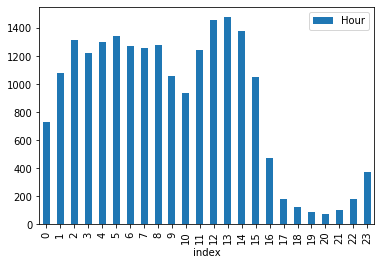

In [22]:
def day_unique_behav(date, behavior_type) -> list:
    '''
    特別驗證一下如果是以 User_Id 來計算不重複活躍的活躍頻率
    '''
    
    day = df_hour[(df_hour['Date'] == date) & (df_hour['Behavior'] == behavior_type)].reset_index(drop=True)
    day = day.Hour.value_counts().reset_index().sort_values(by='index').set_index('index').plot(kind='bar')
#     day = day.groupby(['Date', 'Hour', 'Behavior'])['User_Id'].nunique().reset_index()
    
    return day

day_unique_behav('2017-11-28', 'buy')
# df_hour[df_hour['Date'] == '2017-11-28']

In [23]:
def day_behav(date, col) -> list:
    '''
    選擇特定一天的數據來檢視該天的日期組成
    '''
    day = df_hour[df_hour['Date'] == date].pivot_table(index="Hour", columns="Behavior", aggfunc=['count']).iloc[:, :4]
    day.columns = ['buy', 'cart', 'fav', 'pv']
    hour = day.loc[:, col].to_list()
    return hour
# day_behav('2017-11-28', 'buy')

In [26]:
def day_chart(date):
    hours = np.arange(24).tolist()
    bar = (
        Bar()
        .add_xaxis(hours)
        .add_yaxis("購買量", day_behav(date, 'buy'), stack="stack_1", category_gap=10)
        .add_yaxis("購物車數量", day_behav(date, 'cart'), stack="stack_1", category_gap=10)
        .add_yaxis("我的最愛", day_behav(date, 'fav'), stack="stack_1", category_gap=10)
        .set_series_opts(
            label_opts=opts.LabelOpts(is_show=False)
        )
        .set_global_opts(
            title_opts=opts.TitleOpts(
                title="{} 用戶變化週期曲線".format(date)
            ),
            legend_opts=opts.LegendOpts(
                pos_top="5%"
            )
        )
    )
    
    line = (
        Line()
        .add_xaxis(hours)
        .add_yaxis("瀏覽人次", day_behav(date, 'pv'))
        .set_global_opts(
            title_opts=opts.TitleOpts(
                title="用戶瀏覽人次",
                pos_top="48%",
            ),
            legend_opts=opts.LegendOpts(
                pos_top="50%"
            )
        )
    )
    
    # 把兩張表格合在一起
    grid = (
        Grid()
        .add(bar, grid_opts=opts.GridOpts(pos_bottom="60%"))
        .add(line, grid_opts=opts.GridOpts(pos_top="60%"))
    )
    
    return grid

day_chart('2017-11-28').render_notebook()

## 產品銷售樹圖

### 用戶複購率

In [27]:
df_product = df.query('Behavior == "buy"').loc[:, ['User_Id', 'Behavior']]
df_re = df_product.groupby('User_Id')['Behavior'].count().reset_index().groupby('Behavior')['User_Id'].count().reset_index()
df_re.columns = ['Purchase_times', 'Volume']
df_re.head()

,Purchase_times,Volume
0,1,23196
1,2,14707
2,3,9108
3,4,5479
4,5,3411


In [28]:
def repurchase_rate():
    purchase_list = df_re.Volume.to_list()
    
    bar = (
        Bar(
            init_opts=opts.InitOpts(
                width='1050px'
            )
        )
        .add_xaxis(np.arange(1,84).tolist())
        .add_yaxis("購買人數", purchase_list)
        .set_series_opts(
            label_opts=opts.LabelOpts(is_show=False)
        )
        .set_global_opts(
            title_opts=opts.TitleOpts(
                title="用戶購買次數與人數"
            ),
            legend_opts=opts.LegendOpts(
                pos_top="5%"
            )
        )   
    )
    return bar

repurchase_rate().render_notebook()

In [29]:
# 總購買人數
total_buyer = df_product.User_Id.nunique()
total_purchase = df_product.Behavior.count()
repurchase_count = df_re.Volume[1:].sum()
print('平均購買次數： {:.2f} 次'.format(total_purchase / total_buyer))
print('複購率： {:.2f}%'.format(100 * repurchase_count / total_buyer))

平均購買次數： 2.81 次
複購率： 62.87%


### 銷售最佳排行

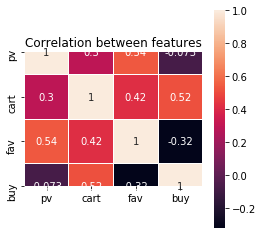

In [100]:
# 計算各個欄位之間 Top 20 的相關性

# 設定搜尋資料庫
df_item = df[['Item_Id', 'Behavior']]

def item_corr():
    item_list = []
    for behav_type in ['pv', 'cart', 'fav', 'buy']:
        behav = df_item[df_item['Behavior'] == behav_type]
        ranking = behav.groupby('Item_Id')['Behavior'].count().reset_index()
        ranking_sorted = ranking.sort_values('Behavior', ascending=False)
        ranking_sorted.columns = ['Item_Id', behav_type]
        item_list.append(ranking_sorted)
    
    all_items = pd.merge(item_list[0], item_list[1], how='inner')
    all_items = pd.merge(all_items, item_list[2], how='inner')
    all_items = pd.merge(all_items, item_list[3], how='inner')
    
    all_items = all_items.iloc[:20,:].fillna(0)
    
    corr = all_items[['pv', 'cart', 'fav', 'buy']].corr()
    
    f, ax= plt.subplots(figsize = (4, 4))
    sns.heatmap(corr, linewidths = 0.05, annot=True, square=True, ax = ax)
    ax.set_title('Correlation between features')
    f.savefig('item_hotmap.png', dpi=300, bbox_inches='tight')
    
item_corr()

In [36]:
# 計算各個欄位之間 Top 20 的相關性

# 設定搜尋資料庫
df_item = df[['Item_Id', 'Behavior']]

def items_corr():
    '''
    篩選前 20 名的產品 ID
    '''
    # create a DataFrame to calculate the corr
    top_twenty_items = pd.DataFrame([])
    
    for behav_type in ['pv', 'cart', 'fav', 'buy']:
        behav = df_item[df_item['Behavior'] == behav_type]
        ranking = behav.groupby('Item_Id')['Behavior'].count().reset_index().sort_values('Behavior', ascending=False)
        top_twenty_rank = ranking.iloc[:20,:].reset_index(drop=True)
        top_twenty_items[behav_type] = top_twenty_rank['Behavior']
    
    # calculate the corr between the different type
    corr = top_twenty_items[['pv', 'cart', 'fav', 'buy']].corr()
        
    return corr

items_corr()

,pv,cart,fav,buy
pv,1.000000,0.953931,0.897811,0.942620
cart,0.953931,1.000000,0.926883,0.941766
fav,0.897811,0.926883,1.000000,0.793080
buy,0.942620,0.941766,0.793080,1.000000


In [59]:
import json

# 設定搜尋資料庫
df_item = df[['Item_Id', 'Behavior']]

def search_item_sales(behavior_Type):
    # 篩選前 20 名的產品 ID
    behav = df_item[df_item['Behavior'] == behavior_Type]
    ranking = behav.groupby('Item_Id')['Behavior'].count().reset_index().sort_values('Behavior', ascending=False)
    top_twenty_rank = ranking.iloc[:20,:].reset_index(drop=True).to_dict()
    
    # 進行資料轉換並儲存成 list 型態以供 pyechart tree Map 使用
    item_list = []
    for rank in range(20):
        treemap = {}
        treemap['value'] = top_twenty_rank['Behavior'][rank]
        treemap['name'] = top_twenty_rank['Item_Id'][rank]
        item_list.append(treemap)
    
    return item_list

In [60]:
def item_ranking(Behavior_Type, title) -> TreeMap:
    data = [
        {
            "name": Behavior_Type,
            "children": search_item_sales(Behavior_Type),   
        }
    ]
    
    treemap = (
        TreeMap(
            init_opts=opts.InitOpts(theme="light")
        )
        .add("數量", data, is_selected=True, roam='move',
             label_opts=opts.LabelOpts(
                 position='inside'
             )   
        )
        .set_global_opts(
            title_opts=opts.TitleOpts(
                title=title
            )
        )
    )
    return treemap
item_ranking('buy', '商品銷售排行').render_notebook()

In [61]:
# 顯示購物車排行
item_ranking('cart', '購物車商品排行').render_notebook()

In [62]:
# 顯示我的最愛排行
item_ranking('fav', '我的最愛商品排行').render_notebook()

In [63]:
# 顯示瀏覽次數排行
item_ranking('pv', '商品瀏覽排行').render_notebook()

## RFM MODEL

In [177]:
# Tricky way to solve it
df_rfm = df_behav.query('Behavior == "buy"').loc[:, ['User_Id', 'Date', 'Time']]
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175732 entries, 67 to 8797427
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   User_Id  175732 non-null  category      
 1   Date     175732 non-null  category      
 2   Time     175732 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](1)
memory usage: 6.8 MB


In [164]:
r = df_rfm.groupby('User_Id')['Time'].max().reset_index().dropna(axis=0, how='any')

In [169]:
r['Recency'] = (pd.to_datetime('2017-12-03') - r['Time']).dt.days
r.drop('Time', axis=1, inplace=True)

In [252]:
r[r['Recency'] > 0].head()

,User_Id,Recency
5,27,1
9,100,4
11,117,4
13,119,3
14,121,7


In [201]:
# 進行 F 的計算
f = df_rfm.groupby(['User_Id'])['Time'].count().reset_index()
f = f[f['Time'] > 0].reset_index(drop=True)
f.columns = ['User_Id', 'Frequency']
f.head()

,User_Id,Frequency
0,27,2
1,43,5
2,100,8
3,117,10
4,119,3


In [267]:
def boxplot_r() -> Boxplot:
    '''
    製作 r 的四分位圖
    '''
    r_data = r.Recency.to_list()
    prepared = Boxplot().prepare_data([r_data])
    
    boxplot = (
        Boxplot()
        .add_xaxis(["Rrecency"])
        .add_yaxis("", prepared)
        .set_global_opts(
            title_opts=opts.TitleOpts(
                title="Recency 資料分布"
            ),
            legend_opts=opts.LegendOpts(
                pos_top="5%"
            )
        )
    )
    return boxplot
boxplot_r().render_notebook()

In [266]:
def boxplot_f() -> Boxplot:
    '''
    製作 r 的四分位圖
    '''
    f_data = f.Frequency.to_list()
    prepared = Boxplot().prepare_data([f_data])
    
    boxplot = (
        Boxplot()
        .add_xaxis(["Frequency"])
        .add_yaxis("", prepared)
        .set_global_opts(
            title_opts=opts.TitleOpts(
                title="Frequency 資料分布"
            ),
            legend_opts=opts.LegendOpts(
                pos_top="5%"
            )
        )
    )
    return boxplot
boxplot_f().render_notebook()

In [200]:
# 整合兩個欄位
rfm_table = pd.merge(r, f, left_on='User_Id', right_on='User_Id', how='inner')
rfm_table.head()

,User_Id,Recency,Frequency
0,27,1,2
1,43,0,5
2,100,4,8
3,117,4,10
4,119,3,3


In [234]:
# 查詢四分位數
rfm_table.quantile([.25, .5, .75])

,Recency,Frequency
0.25,0.0,1.0
0.50,2.0,2.0
0.75,4.0,3.0


In [237]:
rfm_table['R_Score'] = pd.cut(rfm_table['Recency'], bins=[0, 2, 4, 11], labels=[3,2,1], right=False).astype('float')
rfm_table['F_Score'] = pd.cut(rfm_table['Frequency'], bins=[1, 2, 3, 4, 5, 100000], labels=[5,4,3,2,1], right=False).astype('float')

In [241]:
rfm_table

,User_Id,Recency,Frequency,R_Score,F_Score,R_Big_then_Avg,F_Big_then_Avg
0,27,1,2,3.0,4.0,1,1
1,43,0,5,3.0,1.0,1,0
2,100,4,8,1.0,1.0,0,0
3,117,4,10,1.0,1.0,0,0
4,119,3,3,2.0,3.0,0,0
...,...,...,...,...,...,...,...
62473,1017960,1,2,3.0,4.0,1,1
62474,1017965,5,1,1.0,5.0,0,1
62475,1017972,3,4,2.0,2.0,0,0
62476,1017997,2,2,2.0,4.0,0,1


In [240]:
# 進行依平均分組
rfm_table['R_Big_then_Avg'] = (rfm_table['R_Score'] > rfm_table['R_Score'].mean()) * 1
rfm_table['F_Big_then_Avg'] = (rfm_table['F_Score'] > rfm_table['F_Score'].mean()) * 1

In [243]:
# 進行組別編號
rfm_table['Type'] = (rfm_table['R_Big_then_Avg'] * 10 + rfm_table['F_Big_then_Avg'] * 1)

In [270]:
mapping_type = {
    0: "重點挽留用戶",
    1: "一般保持用戶",
    10: "潛在消費用戶",
    11: "重要價值用戶"
}

# 分組計算
rfm_type = rfm_table.Type.value_counts().reset_index()
rfm_type.columns = ['Type', 'Count']

# 映射分類欄位
rfm_type['Type'] = rfm_type.Type.map(mapping_type)

# 計算比例
rfm_type['Ratio'] = round(100 * rfm_type.Count / rfm_type.Count.sum(), 1)

# 顯示結果
rfm_type

,Type,Count,Ratio
0,一般保持用戶,24675,39.5
1,潛在消費用戶,14783,23.7
2,重要價值用戶,13228,21.2
3,重點挽留用戶,9792,15.7


In [271]:
# 繪製 RFM 表格
def rfm_chart():
    pie = (
        Pie()
        .add("", [list(z) for z in zip(rfm_type.Type.to_list(), rfm_type.Ratio.to_list())])
        .set_global_opts(title_opts=opts.TitleOpts(title="RF 用戶分類圖"))
        .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}%"))
    )
    return pie
rfm_chart().render_notebook()